[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/astroML/astroML-notebooks/main?filepath=chapter6/Figure6-6.ipynb)

# Gaussian Mixture Models Example

## Introduction
**Gaussian mixture model** is a relatively simple and straightfoward numerical method on obtaining data likelihood function, and expectation maximization algorithm for maximizing the likelihood.  
The likelihood of a datum $x_i$ for a Gaussian mixture model is given by  

$$p(x_i|\theta) = \sum_{j=1}^{M} \alpha_{j}\mathcal{N}(\mu_j, \sigma_j)$$  

where vector of parameters $\theta$ is estimated from Gaussian with parameters $\mu_j$ and $\sigma_j$.   
$\alpha_j$ is the normalization factor for each Gaussian, with $\sum_{j=1}^{M} \alpha_{j} = 1$.   
M is given.
  
Both **Akaike information criterion (AIC)** and **Bayesian information criterion (BIC)** are scoring systems for model comparisons in classical statistics dealing with models with different numbers of free parameters.  

Specifically, **AIC** is computed as

$$AIC \equiv -2 ln(L^0(M)) + 2k + \frac{2k(k+1)}{N-k-1}$$  

**BIC** is computed as

$$BIC \equiv -2ln[L^0(M)] + k lnN$$  
  
In this notebook, we are going to apply Gaussian mixture model on a dataset of stellar metallicity. Then we will use AIC, and BIC for model comparisons, and then plot the best scored model in BIC.   

### 1. Import data and functions
The main function we use in this section is GaussianMixture from sklearn package. The data we use in the example is from a subset of SEGUE Stellar Parameters data, in which the parameters are estimated using (SEGUE Stellar Parameters Pipeline). Data reference from [Beers et al 2006](https://ui.adsabs.harvard.edu/abs/2006IAUJD..13E..26B/abstract).

In [4]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture

from astroML.datasets import fetch_sdss_sspp
from astroML.plotting.tools import draw_ellipse

### 2. Get the Segue Stellar Parameters Pipeline data

In [5]:
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

### 3. Compute Gaussian Mixture models & AIC/BIC
We calculate Gaussian Mixture model using compute_GaussianMixture, and take AIC/BIC from calculated models. 
We will evaluate between 1 and 13 Gaussian components of the model, and pick the number of components with the lowest BIC score.

In [6]:
N = np.arange(1, 14)

def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

best fit converged: True
BIC: n_components =  5


### 4. Compute 2D density

In [ ]:
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(list(map(np.ravel,
                          np.meshgrid(0.5 * (FeH_bins[:-1]
                                             + FeH_bins[1:]),
                                      0.5 * (alphFe_bins[:-1]
                                             + alphFe_bins[1:]))))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

### 5. Plot true data density

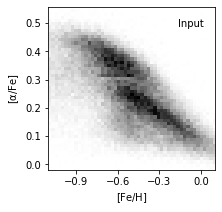

In [ ]:
fig = plt.figure(figsize=(3, 3))

# define plot_figure to plot all figures with the same format.
def plot_figure(number, data, text):
    ax = fig.add_subplot(number)
    ax.imshow(data,
              origin='lower', interpolation='nearest', aspect='auto',
              extent=[FeH_bins[0], FeH_bins[-1],
                      alphFe_bins[0], alphFe_bins[-1]],
              cmap=plt.cm.binary)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
    ax.set_xlabel(r'$\rm [Fe/H]$')
    ax.set_xlim(-1.101, 0.101)
    ax.text(0.93, 0.93, text,
            va='top', ha='right', transform=ax.transAxes)
    ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
    return ax

ax = plot_figure(111, H.T, "Input")
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
plt.show()

### 6. Plot AIC/BIC
We pick the N value for smallest score in BIC for the following calculations.

[None, None, None, None, None, None, None, None, None, None, None, None]

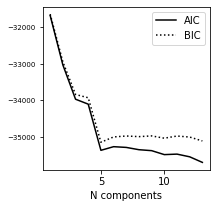

In [ ]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

### 7. Best configurations for BIC
Taking N = 5 components as the result of BIC evaluation, we plot the best estimated model.   
The reconstructed density are in grayscale. The Gaussians are solid ellipses in the figure. 

Text(0, 0.5, '$\\rm [\\alpha/Fe]$')

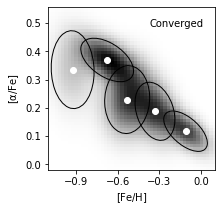

In [ ]:
fig = plt.figure(figsize=(3,3))

ax = plot_figure(111, np.exp(log_dens), "Converged")

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.set_ylabel(r'$\rm [\alpha/Fe]$')

### 8. Compare input data and converged model
We plot the input true density distribution and best scored model from BIC in comparison. As a result, we find component number = 5 best discribes this metallicity dataset. 

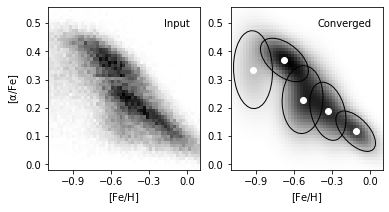

In [ ]:
fig = plt.figure(figsize=(6, 3))

# plot density
ax1 = plot_figure(121, H.T, "Input")
ax1.set_ylabel(r'$\rm [\alpha/Fe]$')

ax2 = plot_figure(122, np.exp(log_dens), "Converged")
ax2.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax2, fc='none', ec='k')